In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

import energyflow as ef
import torch
import torch.nn as nn
import os.path as osp

torch.manual_seed(42)
np.random.seed(42)

In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

In [3]:
from graph_data import GraphDataset
gdata = GraphDataset(root='/energyflowvol/datasets', n_jets=100, n_events_merge=1)
batch_size = 100

In [4]:
gdata

GraphDataset(9801)

In [5]:
from models import DynamicEdgeNet, EdgeNet, DeeperDynamicEdgeNet

In [7]:
input_dim = 3
big_dim = 32
bigger_dim = 128
global_dim = 2
output_dim = 1
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
lr = 0.001
device = 'cuda:0'
model_fname = 'DeeperDynamicEdgeNet'
modpath = osp.join('/energyflowvol/lhco_models/',model_fname+'.best.pth')

model = DeeperDynamicEdgeNet(input_dim=input_dim, big_dim=big_dim, bigger_dim=bigger_dim, 
                global_dim=global_dim, output_dim=output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

try:
    if torch.cuda.is_available():
        print("Using GPU")
        model.load_state_dict(torch.load(modpath, map_location=torch.device('cuda')))
    else:
        model.load_state_dict(torch.load(modpath, map_location=torch.device('cpu')))
except:
    print("no model")
    pass # new model

Using GPU


In [8]:
from torch_geometric.data import Data, DataLoader, DataListLoader, Batch
from torch.utils.data import random_split

train_dataset, valid_dataset, test_dataset = random_split(gdata, [fulllen-2*tv_num,tv_num,tv_num])

def collate(items): # collate function for data loaders (transforms list of lists to list)
    l = sum(items, [])
    return Batch.from_data_list(l)

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
valid_loader.collate_fn = collate
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader.collate_fn = collate

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)

7839
981
981


In [9]:
import tqdm
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [ ]:
n_epochs = 100
patience = 10
stale_epochs = 0
best_valid_loss = 99999
losses = []
val_losses = []
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    losses.append(loss)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    val_losses.append(valid_loss)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

In [10]:
model.load_state_dict(torch.load(modpath))
ys = []
preds = []
diffs = []

from graph_data import ONE_HUNDRED_GEV

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    ys.append(data.y.cpu().numpy().squeeze()*ONE_HUNDRED_GEV)
    preds.append(model(data).cpu().detach().numpy().squeeze()*ONE_HUNDRED_GEV)
    
ys = np.concatenate(ys)   
preds = np.concatenate(preds)   
diffs = (preds-ys)
rel_diffs = diffs[ys>0]/ys[ys>0]

 92%|█████████▏| 9/9.81 [02:25<00:13, 16.05s/it]/opt/conda/lib/python3.7/site-packages/tqdm/std.py:527: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
102%|██████████| 10/9.81 [02:38<-1:59:57, 15.84s/it]


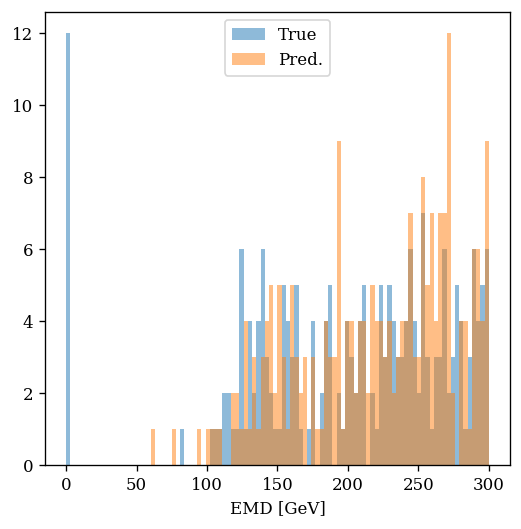

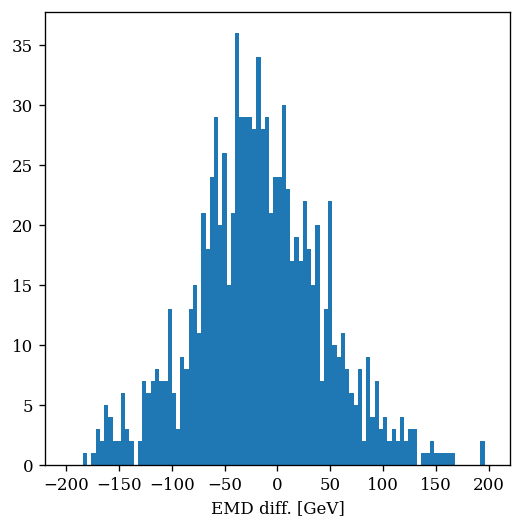

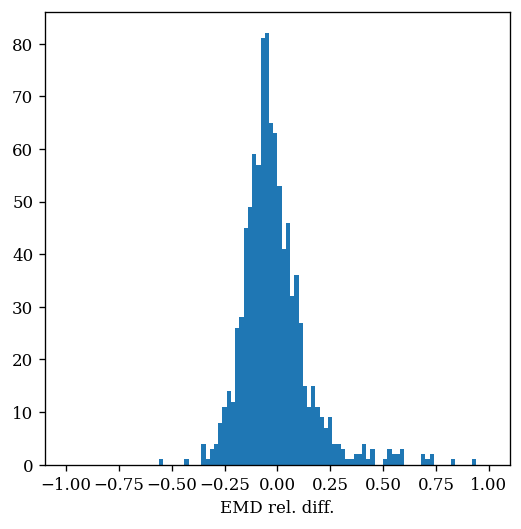

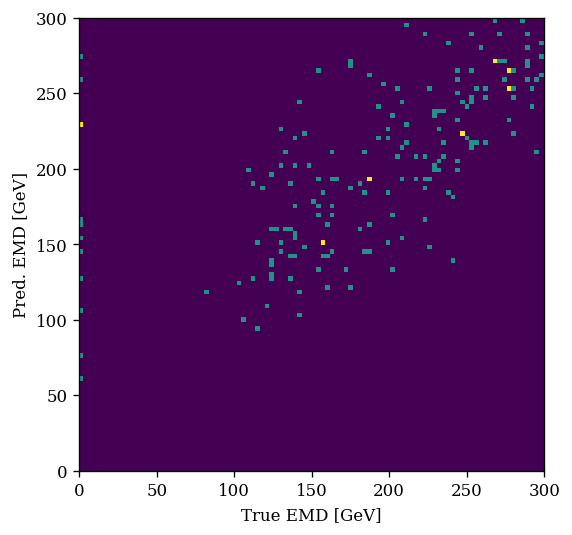

In [11]:
# fig, ax = plt.subplots(figsize =(5, 5)) 
# plt.plot(losses, marker='o',label='Training', alpha=0.5)
# plt.plot(val_losses, marker='o',label = 'Validation', alpha=0.5)
# plt.legend()
# ax.set_ylabel('Loss') 
# ax.set_xlabel('Epoch') 
# fig.savefig('/energyflowvol/models/'+model_fname+'_loss.pdf')
# fig.savefig('/energyflowvol/models/'+model_fname+'_loss.png')

fig, ax = plt.subplots(figsize =(5, 5)) 
plt.hist(ys, bins=np.linspace(0, 300, 101),label='True', alpha=0.5)
plt.hist(preds, bins=np.linspace(0, 300, 101),label = 'Pred.', alpha=0.5)
plt.legend()
ax.set_xlabel('EMD [GeV]') 
fig.savefig('/energyflowvol/models/'+model_fname+'_EMD.pdf')
fig.savefig('/energyflowvol/models/'+model_fname+'_EMD.png')

fig, ax = plt.subplots(figsize =(5, 5)) 
plt.hist(diffs, bins=np.linspace(-200, 200, 101))
ax.set_xlabel('EMD diff. [GeV]')  
fig.savefig('/energyflowvol/models/'+model_fname+'_EMD_diff.pdf')
fig.savefig('/energyflowvol/models/'+model_fname+'_EMD_diff.png')


fig, ax = plt.subplots(figsize =(5, 5)) 
plt.hist(rel_diffs, bins=np.linspace(-1, 1, 101))
ax.set_xlabel('EMD rel. diff.')  
fig.savefig('/energyflowvol/models/'+model_fname+'_EMD_rel_diff.pdf')
fig.savefig('/energyflowvol/models/'+model_fname+'_EMD_rel_diff.png')

fig, ax = plt.subplots(figsize =(5, 5)) 
x_bins = np.linspace(0, 300, 101)
y_bins = np.linspace(0, 300, 101)
plt.hist2d(ys, preds, bins=[x_bins,y_bins])
ax.set_xlabel('True EMD [GeV]')  
ax.set_ylabel('Pred. EMD [GeV]')
fig.savefig('/energyflowvol/models/'+model_fname+'_EMD_corr.pdf')
fig.savefig('/energyflowvol/models/'+model_fname+'_EMD_corr.png')